
Finetuning Torchvision Models
=============================
[tutorial](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html) | [models](https://pytorch.org/vision/stable/models.html) | [datasets](https://pytorch.org/vision/stable/datasets.html)


transfer learning:  
[cs231n](https://cs231n.github.io/transfer-learning), [ruder.io](https://ruder.io/transfer-learning)

pytorch HowTo's:  
[save weights after training](https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html)  
[load weights for inference](https://towardsdatascience.com/how-to-save-and-load-a-model-in-pytorch-with-a-complete-example-c2920e617dee)  
[use ADAM or ADAMW instead of SGD](https://analyticsindiamag.com/ultimate-guide-to-pytorch-optimizers/)  


TODO's:
* infer on test dataset and give some insights
* try > resolution 224 [discussion](https://discuss.pytorch.org/t/transfer-learning-usage-with-different-input-size/20744/6)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
#from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import time
from PIL import Image

# Helper Functions:
from libs.model_definitions import initialize_model
from libs.train_model import train_model
from libs.dataset_utils import get_transforms
from libs import splitfolders

%matplotlib inline

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118


Settings
----------------

In [2]:
# data directory with [train, val, test] dirs
data_dir = "./dataset/views_split"

# train / val / test split
split_ratio = (.8, .1, .1)  
copy_dataset=True

# number of data loader workers
dloader_workers = 6

# Number of classes in the dataset
num_classes = 6   # TODO: len(image_datasets['train'].classes) or from folders


model_list =    ["resnet18", "resnet50", "alexnet", "vgg11_bn", "squeezenet", "densenet121", "inception_v3", "mobilenet_v2", 
                "mobilenet_v3_large", "regnet_y_16gf", "efficientnet_v2_s", "efficientnet_v2_m", "convnext_base", "swin_v2_b"]

model_type = "mobilenet_v3_large"

model_name = "photo-sanitizer-v02"
checkpoints_dir = "checkpoints/"
checkpoint_path = os.path.join(checkpoints_dir, model_name + ".pt")

add_softmax = True

# Feature Augmentation
scale_range = (0.75, 1.2)

# Deivce
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Batch size for training (change depending on how much memory you have)
batch_size = 20

# Number of epochs to train for 
num_epochs = 30

learning_rate = 1e-4

# train all layers or just head layer
train_deep = True

# ImageNet Constants
mean = np.array([0.485, 0.456, 0.406])  # [0.485, 0.456, 0.406] 
std =  np.array([0.229, 0.224, 0.225])  # [0.229, 0.224, 0.225]


# check if model_type exists
if not model_type in model_list:
    print(f"ERROR: model {model_type} unknown!")


### Split Dataset

In [3]:
# check if dataset is already splitted
if not splitfolders.check_existence(data_dir, dirs=["val", "test", "train"]):
    
    # create output path for splitted dataset
    split_data_dir = os.path.join(os.path.split(data_dir)[0], os.path.split(data_dir)[1]+"_split")

    # copy or move dataset split into train, validation and test
    splitfolders.ratio(data_dir, 
                       output=split_data_dir, 
                       seed=1337, ratio=split_ratio,
                       group_prefix=None, 
                       move=not(copy_dataset))

    data_dir = split_data_dir

Helper Functions
----------------






initialize model:

In [4]:
# Initialize the model for this run
model, input_size = initialize_model(model_type, num_classes, train_deep, add_softmax=add_softmax)

replace Colab imshow with custom function for use in Jupyter

In [5]:
def convert_tensor_to_array(image, idx=0):
    # from libs.dataset_utils import convert_image_to_cv
    # img = convert_image_to_cv(image, RGB2BGR=False, normalized=True)

    img = image.cpu().data[idx].numpy().transpose((1, 2, 0))        # [-1 |  1 ]
    img = np.clip((std * img + mean)*255, 0, 255).astype(np.uint8)  # [ 0 | 255]
    return img

time helper

In [6]:
def get_current_date():
    return time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())

JSON helper

In [7]:
# write model metadata to json file
def save_json(data, dirpath, model_name, update=True):
    jsonpath = os.path.join(dirpath, model_name + "_metadata.json")

    if update:
        with open(jsonpath) as f:
            data_old = json.load(f)
        data_old.update(data)
        data = data_old
    
    with open(jsonpath, 'w') as f:
        json.dump(data, f)

Load Data
---------

Now that we know what the input size must be, we can initialize the data
transforms, image datasets, and the dataloaders. Notice, the models were
pretrained with the hard-coded normalization values, as described
`here <https://pytorch.org/docs/master/torchvision/models.html>`__.




In [8]:
# Data augmentation and normalization for training: http://pytorch.org/vision/main/transforms.html
# TODO: or use https://albumentations.ai instead

data_transforms = get_transforms(input_size, scale_range=scale_range, hflip=0.5)

In [9]:
# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=dloader_workers) for x in ['train', 'val']}

class_names = image_datasets['train'].classes
print("class_names:", class_names)

class_names: ['background', 'down', 'front', 'left', 'missing', 'up']


In [10]:
def visualize_model(model, device=device, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders_dict['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))

                img = convert_tensor_to_array(inputs, idx=j)
                plt.imshow(img)
            
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
        model.train(mode=was_training)

Create the Optimizer
--------------------

Now that the model structure is correct, the final step for finetuning
and feature extracting is to create an optimizer that only updates the
desired parameters. Recall that after loading the pretrained model, but
before reshaping, if ``train_deep=False`` we manually set all of the
parameter’s ``.requires_grad`` attributes to False. Then the
reinitialized layer’s parameters have ``.requires_grad=True`` by
default. So now we know that *all parameters that have
.requires_grad=True should be optimized.* Next, we make a list of such
parameters and input this list to the SGD algorithm constructor.

To verify this, check out the printed parameters to learn. When
finetuning, this list should be long and include all of the model
parameters. However, when feature extracting this list should be short
and only include the weights and biases of the reshaped layers.




In [11]:
# Send the model to GPU if possible
model = model.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
#print("Params to learn:")
if not train_deep:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            #print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            #print("\t",name)
            continue

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=learning_rate)
# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)


Run Training and Validation Step
--------------------------------

Finally, the last step is to setup the loss for the model, then run the
training and validation function for the set number of epochs. Notice,
depending on the number of epochs this step may take a while on a CPU.
Also, the default learning rate is not optimal for all of the models, so
to achieve maximum accuracy it would be necessary to tune for each model
separately.




In [12]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

starttime = time.time()

# Train and evaluate
model, hist = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, device=device)

training_duration = time.time() - starttime

Epoch 0/29
----------
train Loss: 1.5926 Acc: 0.6298
val Loss: 1.4685 Acc: 0.7083

Epoch 1/29
----------
train Loss: 1.1799 Acc: 0.9216
val Loss: 1.1861 Acc: 0.8958

Epoch 2/29
----------
train Loss: 1.0872 Acc: 0.9692
val Loss: 1.0938 Acc: 0.9688

Epoch 3/29
----------
train Loss: 1.0650 Acc: 0.9871
val Loss: 1.0800 Acc: 0.9792

Epoch 4/29
----------
train Loss: 1.0585 Acc: 0.9897
val Loss: 1.0639 Acc: 0.9896

Epoch 5/29
----------
train Loss: 1.0556 Acc: 0.9949
val Loss: 1.0660 Acc: 0.9792

Epoch 6/29
----------
train Loss: 1.0502 Acc: 0.9974
val Loss: 1.0597 Acc: 0.9896

Epoch 7/29
----------
train Loss: 1.0461 Acc: 1.0000
val Loss: 1.0598 Acc: 0.9896

Epoch 8/29
----------
train Loss: 1.0488 Acc: 0.9961
val Loss: 1.0548 Acc: 0.9896

Epoch 9/29
----------
train Loss: 1.0486 Acc: 0.9974
val Loss: 1.0661 Acc: 0.9792

Epoch 10/29
----------
train Loss: 1.0484 Acc: 0.9961
val Loss: 1.0676 Acc: 0.9688

Epoch 11/29
----------
train Loss: 1.0503 Acc: 0.9949
val Loss: 1.0844 Acc: 0.9583

Ep

In [13]:
best_val_acc = round(float(max(hist)), 4)
last_val_acc = round(float(hist[-1]), 4)

print("best_val_acc:", best_val_acc)
print("last_val_acc:", last_val_acc)

print(f"Training took {training_duration:.2f} seconds")

best_val_acc: 0.9896
last_val_acc: 0.9479
Training took 101.93 seconds


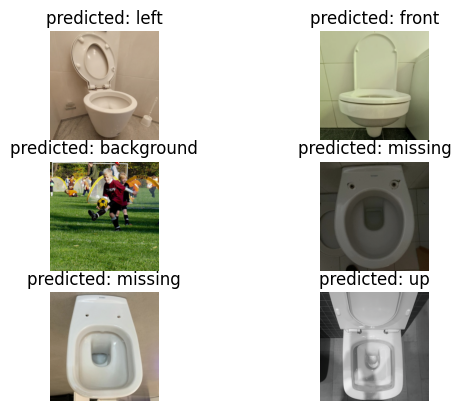

In [14]:
visualize_model(model, device=device)

### Save Checkpoint
https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html

https://stackoverflow.com/questions/42703500/how-do-i-save-a-trained-model-in-pytorch

In [15]:
# EPOCH = num_epochs  # TODO: current epoch / epoch of best val acc
# LOSS = 0.4          # TODO read from hist
#
# torch.save({
#             'epoch': EPOCH,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer_ft.state_dict(),
#             'loss': LOSS,
#             }, checkpoint_path)


# Save the model
torch.save(model, checkpoint_path)


# Write variables to a JSON file
data = {
    'date_created':             get_current_date(),
    'model_type':               model_type, 
    'input_size':               input_size,
    'has_softmax':              add_softmax,
    'class_names':              class_names, 
    'initial_learning_rate':    learning_rate,
    'epochs':                   num_epochs,
    'training_time':            training_duration,
    'best_val_acc':             best_val_acc,
    'last_val_acc':             last_val_acc
    }

save_json(data, checkpoints_dir, model_name, update=False)

-------------------------------
### Load Checkpoint and Data Loader

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 64

# # Remember to first initialize the model and optimizer, then load the dictionary locally.
# model, input_size = initialize_model(model_type, num_classes, train_deep)
# model = model.to(torch.device(device))

# optimizer = optim.Adam(model.parameters(), lr=0.001)

# checkpoint = torch.load(checkpoint_path)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']


model = torch.load(checkpoint_path)
model = model.to(torch.device(device))

# set dropout and batch normalization layers to evaluation mode before running inference
model.eval()


# create data loader for test-data
test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

## TEST

In [17]:
test_dir = os.path.join(data_dir, "test")

testset = datasets.ImageFolder(test_dir, test_transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

test_acc = 0.0
for samples, labels in test_loader:
    with torch.no_grad():
        samples, labels = samples.to(device), labels.to(device)
        output = model(samples)

        # calculate accuracy
        pred = torch.argmax(output, dim=1)
        correct = pred.eq(labels)
        test_acc += torch.mean(correct.float())

testimage_count = len(testset)
test_result = test_acc.item()/len(test_loader)
print(f'Accuracy of the network on {testimage_count} test images: {round(test_result * 100.0, 2)}%')


Accuracy of the network on 100 test images: 97.05%


In [18]:
# update metadata with test accuracy
data = {'date_modified': get_current_date(), 'test_acc': round(test_result, 2)}
save_json(data, checkpoints_dir, model_name, update=True)

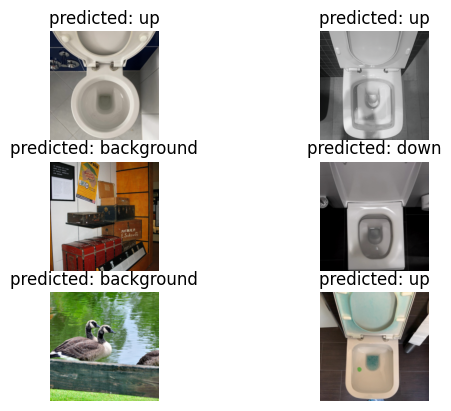

In [19]:
visualize_model(model, device=device, num_images=6)

----------------------------------------
## Inference

In [20]:
def load_image(img_path, device="cpu"):
    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)
    return img


def predict(model, img):
    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)
        return preds
    

def imshow(image, title=None):
    img = convert_tensor_to_array(image)

    ax = plt.subplot(2,2,1)
    ax.axis('off')
    ax.set_title(title)
    plt.imshow(img)
    plt.pause(0.001)

In [21]:
# class UnknownImageDataset(Dataset):
#     def __init__(self, root_dir, transform=None):
#         self.root_dir = root_dir
#         self.transform = transform
#         self.image_files = os.listdir(root_dir)

#     def __len__(self):
#         return len(self.image_files)

#     def __getitem__(self, idx):
#         img_name = os.path.join(self.root_dir, self.image_files[idx])
#         image = Image.open(img_name)
#         if self.transform:
#             image = self.transform(image)
#         return image


# unknown_dir = "./dataset/top"

# unknownset = UnknownImageDataset(unknown_dir, test_transform)
# unknown_loader = torch.utils.data.DataLoader(unknownset, batch_size=batch_size, shuffle=True)

# model.eval() # set the model to evaluation mode

# # iterate over the unknown images
# for inputs in unknown_loader:
#     inputs = inputs.to(device) # move the inputs to the device the model is on
#     outputs = model(inputs) # make predictions
#     _, preds = torch.max(outputs, 1) # get the predicted class


In [22]:
import random


visualize = True
force_CPU = True

dir_path = './dataset/views_unlabeled'
max_images = 5

device = torch.device("cuda:0" if torch.cuda.is_available() and not force_CPU else "cpu")

model = model.to(device)
model.eval()

# create index of all images to predict
filelist = []
for (root,dirs,files) in os.walk(dir_path, topdown=True):
        for i, file in enumerate(files):
            img_path = os.path.join(root,file)
            filelist.append(img_path)

filelist = random.sample(filelist, max_images)

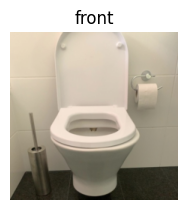

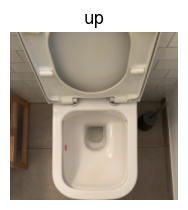

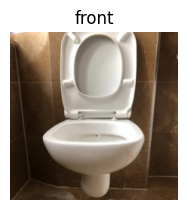

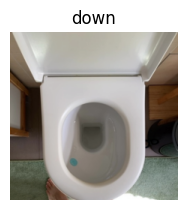

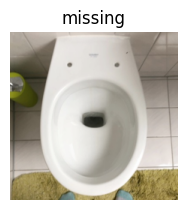

In [23]:
for img_path in filelist:
    img = load_image(img_path, device=device)
    predictions = predict(model, img)
    predicted_label = class_names[predictions[0]]

    if visualize:
        imshow(img, title=predicted_label)

plt.ioff()
plt.show()